#### Universidade de Brasília <br> Departamento de Ciência da Computação
# Projeto 1:
### Teoria e Aplicação de Grafos, Turma 01, 2025/1 <br> Prof. Díbio <br> Integrantes do Grupo: Bruno Henrique (221022239), João Victor Prata (202028857), Manuela ()

## Importar Bibliotecas:

In [11]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
from itertools import combinations

## Coletar Dados:

In [12]:
# Leitura do CSV com pandas
df = pd.read_csv("fake.csv")
# Aqui podemos remover algumas colunas do dataframe que não nos interessam para essa análise com grafos
colunas_desinteressantes = ['uuid', 'language', 'crawled', 'site_url', 'country', 'domain_rank', 'main_img_url', 'spam_score', 'type']
df = df.drop(columns=colunas_desinteressantes, axis=1)
# Elementos iniciais do csv
print(df.head())


   ord_in_thread                author                      published  \
0              0     Barracuda Brigade  2016-10-26T21:41:00.000+03:00   
1              0  reasoning with facts  2016-10-29T08:47:11.259+03:00   
2              0     Barracuda Brigade  2016-10-31T01:41:49.479+02:00   
3              0                Fed Up  2016-11-01T05:22:00.000+02:00   
4              0                Fed Up  2016-11-01T21:56:00.000+02:00   

                                               title  \
0  Muslims BUSTED: They Stole Millions In Gov’t B...   
1  Re: Why Did Attorney General Loretta Lynch Ple...   
2  BREAKING: Weiner Cooperating With FBI On Hilla...   
3  PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...   
4  FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...   

                                                text  \
0  Print They should pay all the back all the mon...   
1  Why Did Attorney General Loretta Lynch Plead T...   
2  Red State : \nFox News Sunday reported this mo...   


## Construir Grafo:

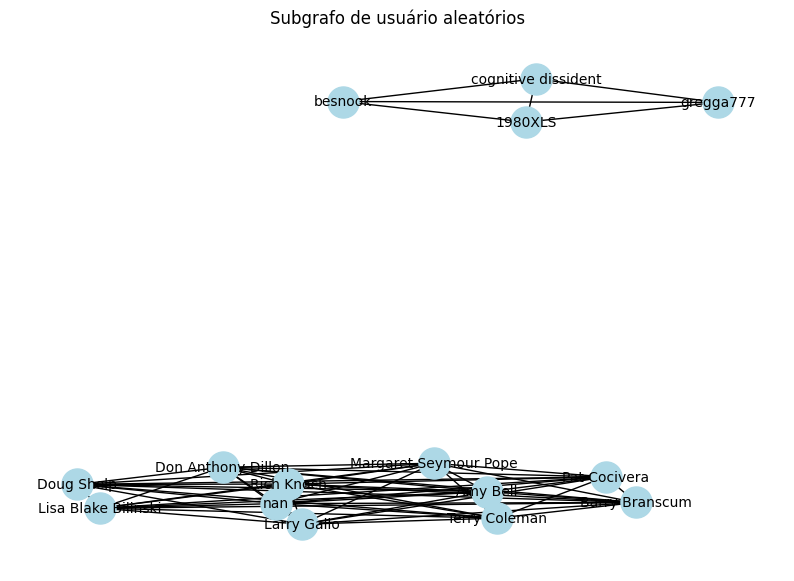

In [20]:
# df.groupby('thread_title') -> Agrupa todo o dataset com base o thread_title
# pode ser descontruído como (thread, grupo) para cada thread presente no dataframe
# Assim, para uma thread x temos todos os autores que estão interagindo sob um tema
G = nx.Graph()
for thread, group in df.groupby('thread_title'):
    autores = group['author'].unique()
    for u1, u2 in combinations(autores, 2):
        if G.has_edge(u1, u2):
            G[u1][u2]['weight'] += 1
        else:
            G.add_edge(u1, u2, weight=1)
# Dado a massividade do grafo armazenado em G, para a visualização dele é melhor compreende-lo com base subgrafos
no_aleatorio = sorted(G.degree, key=lambda x: x[1], reverse=True)[:15]
no_aleatorio = [n for n, _ in no_aleatorio]
subG = G.subgraph(no_aleatorio)
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(subG)

nx.draw_networkx_nodes(subG, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_edges(subG, pos, width=1)
nx.draw_networkx_labels(subG, pos, font_size=10)

plt.title("Subgrafo de usuário aleatórios")
plt.axis('off')
plt.show()



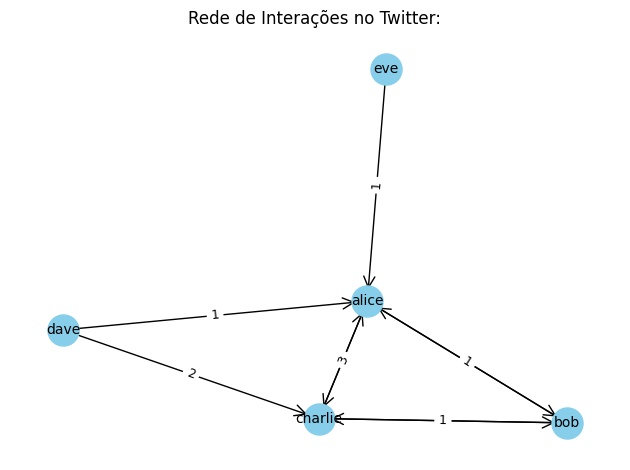

In [4]:
# Criar grafo direcionado:
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(row['user1'], row['user2'], weight=row['weight'])

# Calcular PageRank:
pagerank = nx.pagerank(G, alpha=0.85)

# Detectar comunidades:
communities = greedy_modularity_communities(G)

# Layout dos nós:
pos = nx.spring_layout(G, seed=42)

# Desenhar os nós com tamanho proporcional ao PageRank:
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')

# Desenhar as arestas:
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)

# Desenhar os rótulos dos nós (nomes dos usuários):
nx.draw_networkx_labels(G, pos, font_size=10)

# Desenhar os pesos das arestas:
edge_weights = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, font_size=9)

# Exibir o grafo:
plt.title("Rede de Interações no Twitter:")
plt.axis('off')
plt.tight_layout()
plt.show()